In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
# static balancing methods
from OptimalTransportBalancing import OptimalTransportBalancing as OTB

In [2]:
# use GPU when possible
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
dev = torch.device(dev)

In [3]:
n = 1000
m = 1000
xi = torch.normal(mean = -1, std = 2, size = (n,1))
xi_ring = torch.zeros(size = (m,1))
for i in range(m):
    if torch.rand(1).item()>0.3:
        xi_ring[i,0] = torch.normal(mean = -4, std = 2, size = (1,)).item()
    else:
        xi_ring[i,0] = torch.normal(mean = 3, std = 0.2, size = (1,)).item()
w = torch.ones(n)
w_ring = torch.ones(m)


In [4]:
def viz(weights, xi = xi.detach().numpy(),xi_ring = xi_ring.detach().numpy()):
    plt.figure(figsize = (12,8))
    plt.hist(xi_ring[:,0], alpha = 0.5, bins = 30, label ="target", density = True)
    plt.hist(xi[:,0], alpha = 0.5, bins = 30, label ="source", density = True)
    if weights is not None:
        plt.hist(xi[:,0], weights = weights, alpha = 0.5, bins = 30, label ="re-weighted source", density = True)
    plt.legend()

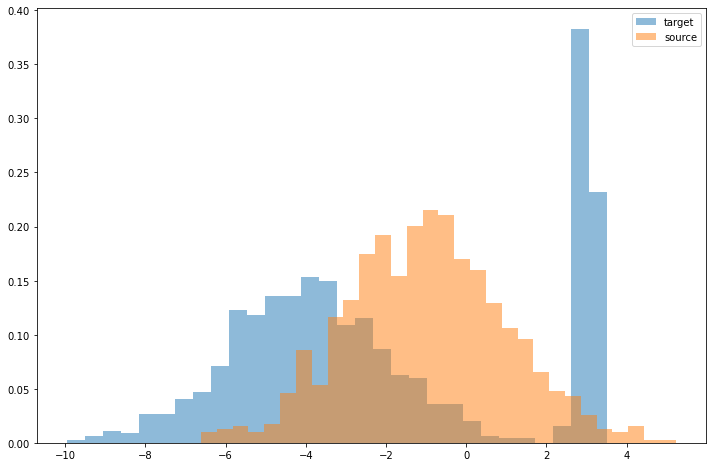

In [5]:
viz(None)

In [6]:
class OptimalTransportBalancing():
    def __init__(self, metric = None):
        """
        Attributes
        ----------
        metric: function (x,y)
            Compute distance between two elements x and y, that are both assumed to be tensors.
        """
        if metric != None:
            self.metric = metric
        else:
            self.metric = lambda x,y : torch.linalg.norm(x-y)
    def get_nearest_neighbor_index (self, x,Y):
        n = Y.shape[0]
        distance_list = torch.zeros(n)
        for i in range(n):
            distance_list[i] = self.metric(x, Y[i])
        return torch.argmin(distance_list).item() 
    def get_weights(self, source, target, source_weights = None, target_weights = None):
        n = len(source)
        m = len(target)
        if source_weights is not None:
            w = source_weights.reshape((n,))
        else:
            w = torch.ones(n)
        if target_weights is not None:
            w_ring = target_weights.reshape((m,))
        else:
            w_ring = torch.ones(m)
        sum_nn_w_ring = torch.zeros(n)
        nearest_neighbor_index = torch.zeros(m, dtype = int)
        for j in range(m):
            nearest_neighbor_index[j] = self.get_nearest_neighbor_index(target[j], source)
        for i in range(n):
            for j in range(m):
                if int(nearest_neighbor_index[j].item()) == i:
                    sum_nn_w_ring[i] += w_ring[j]
        eta_ring = w * sum_nn_w_ring
        return eta_ring *n/m

## Optimal Tranport Balancing wrapper

In [7]:
OTB = OptimalTransportBalancing()

In [8]:
weights_OT = OTB.get_weights(xi,xi_ring,w,w_ring)
weights = weights_OT.detach().numpy()

In [9]:
weights.mean()

1.0

In [10]:
# learning_rate = 1e-2
# g = torch.rand(n, requires_grad = True, device = dev)
# 
# optimizer = torch.optim.Adam([g], lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=True)
# 
# def GD(g = g, learning_rate = 1e-3, lambda_l1 = 1., optimizer = optimizer):
#     obj = (weights_OT.to(dev) - g).square().sum()/n
#     for i in range(n):
#         for j in range(1):
#             obj += lambda_l1*torch.abs(g[i]-g[j])
#     optimizer.zero_grad()
#     obj.backward()
#     optimizer.step()
#     return obj
#     
# 
# 
# 
# 
# epochs = 5000
# loss_trace = []
# for i in tqdm(range(epochs)):
#     loss_trace.append(GD(learning_rate = 1e-2,
#                               lambda_l1 = 1,
#                               ).item())
# plt.plot(np.array(loss_trace))
# viz(g.detach().numpy())

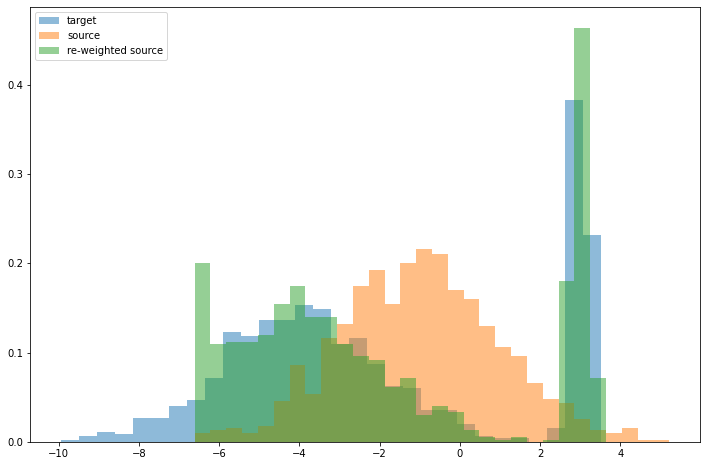

In [11]:
viz(weights)

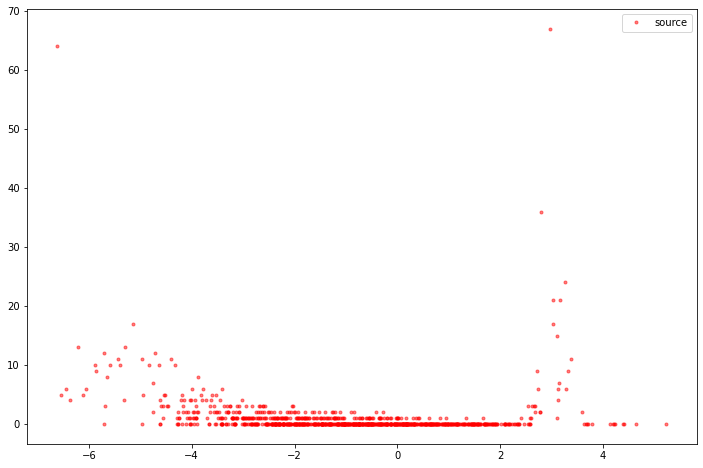

In [12]:

plt.figure(figsize = (12,8))
plt.plot(xi,weights, "r.", alpha = 0.5, label="source")
plt.legend()

In [13]:
print("non-zero ratio: {}".format(np.sum(weights != 0.)/n))
print("larger than 1e-2 ratio: {}".format(np.sum(weights > 1e-2)/n))

non-zero ratio: 0.308
larger than 1e-2 ratio: 0.308


## MMD balancing wrapper


In [14]:
# class MMDBalancing():
#     def __init__(self, kernel = None, k_XX = None, k_XY = None, k_YY = None,):
#         self.k = kernel
#         self.k_XX = k_XX
#         self.k_XY = k_XY
#         self.k_YY = k_YY
#         
#     def GD(self, source, target,
#            weights,
#            source_weights = None,
#            target_weights = None,
#            learning_rate = 0.001,
#            lambda_l2 = 0.,
#            gamma = 0.1):
#                 
#         with torch.no_grad():
#             n = len(source)
#             m = len(target)
#             # generate kernel matrix
#             if self.k_XX == None:
#                 self.k_XX = torch.zeros((n,n))
#                 self.k_XY = torch.zeros((n,m))
#                 self.k_YY = torch.zeros((m,m))
#                 if self.k == None:
#                     self.k = lambda x,y: torch.exp(-torch.linalg.norm(x-y)**2/(gamma*2.0))
#                 print("Calculating kernel matrices...")
#                 for i in range(n):
#                     for j in range(m):
#                         self.k_XY[i,j] = self.k(source[i],target[j])
#                 for i in range(n):
#                     for j in range(n):
#                         self.k_XX[i,j] = self.k(source[i],source[j])
#                 for i in range(m):
#                     for j in range(m):
#                         self.k_YY[i,j] = self.k(target[i],target[j])
#                 print("Kernel matrices constructed!")
#             if source_weights is not None:
#                 w = source_weights/n
#             else:
#                 w = torch.ones(n)/n
#             if target_weights is not None:
#                 w_ring = target_weights/m
#             else:
#                 w_ring = torch.ones(m)/m
#                 
#         MMD = torch.matmul(torch.matmul((w*weights).T,self.k_XX),w*weights) + torch.matmul(torch.matmul(w_ring.T,self.k_YY),w_ring)\
#         - 2.0*torch.matmul(torch.matmul((w*weights).T,self.k_XY),w_ring)
#         MMD_reg = MMD + lambda_l2*weights.square().mean()
#         optimizer = torch.optim.Adam([weights], lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=True)
#         optimizer.zero_grad()
#         MMD_reg.backward()
#         optimizer.step() 
#         return MMD
# 
# 


### Gaussian kernel (slow)

In [15]:
# def k(x,y):
#     return torch.exp(-torch.linalg.norm(x-y)**2/(0.1*2.0))
# def getKM(xi,xi_ring,k = k):
#     n = len(xi)
#     m = len(xi_ring)
#    
#     k_XX = torch.zeros((n,n))
#     k_XY = torch.zeros((n,m))
#     k_YY = torch.zeros((m,m))
#     print("Calculating kernel matrices...")
#     for i in range(n):
#         for j in range(m):
#             k_XY[i,j] = k(xi[i],xi_ring[j])
#     for i in range(n):
#         for j in range(n):
#             k_XX[i,j] = k(xi[i],xi[j])
#     for i in range(m):
#         for j in range(m):
#             k_YY[i,j] = k(xi_ring[i],xi_ring[j])
#     return k_XX,k_XY,k_YY

### Gaussian kernel with random Fourier features (fast)

```D```: number of Fourier random features.

```d```: dimension of the state space.

The idea is to draw
$$
w_1,\dots, w_D \sim \mathcal{N}(0,\sigma^2I_d),
$$
and
$$
\theta_1,\dots, \theta_D \sim \mathrm{Unif}([0,2\pi]).
$$
The random feature map is defined by
$$
\forall j \in [D],\quad
\phi_j(x) = \cos(w_j\cdot x + \theta_j). 
$$

In [16]:
#n,d = xi.shape
#D = 1000
#W = torch.normal(0,5,(D,d), device = dev)
#theta = torch.rand(D, device  = dev)*2*torch.pi
#def get_phi_matrix(xi,
#                   D,
#                   W = W,
#                   theta = theta,
#                   d = d,
#                   dev = dev):
#    n,d = xi.shape
#    xi = xi.clone().to(dev)
#    Phi = torch.zeros((n,D), device = dev)
#    for j in range(D):
#        Phi[:,j] = torch.cos(torch.matmul(W[j,:].T,xi.T) + theta[j])
#    return Phi 


In [113]:
class MMDBalancing():
    def __init__(self,
                 xi, xi_ring,
                 w = None, w_ring = None,
                 sigma = 1, D = 500,
                 k = None, KXX = None, KXY = None, KYY = None,
                 dev = "cuda:0"):
        # init device
        self.dev = dev
        # init support of source and target measures
        self.xi = xi.to(self.dev) 
        self.xi_ring = xi_ring.to(self.dev)
        self.n,self.d = xi.shape
        self.m = xi_ring.shape[0]
        # init weights of source and target measures
        if w is not None:
            self.w = w.to(self.dev)
        else:
            self.w = torch.ones(n, device =self.dev)
        if w_ring is not None:
            self.w_ring = w_ring.to(self.dev)
        else:
            self.w_ring = torch.ones(m, device =self.dev)
        # init kernel matrices, when not provided, Gaussian kernel with random Fourier features is implemented
        if (KXX and KXY and KYY) is not None:
            self.KXX,self.KXY,self.KYY = KXX,KXY,KYY
        else:
            W = torch.normal(0,sigma,(D,self.d), device = self.dev)
            theta = torch.rand(D, device  = self.dev)*2*torch.pi
            Phi_X = torch.zeros((self.n,D), device = self.dev)
            Phi_Y = torch.zeros((self.m,D), device = self.dev)
            for j in range(D):
                Phi_X[:,j] = torch.cos(torch.matmul(W[j,:].T,self.xi.T) + theta[j])
                Phi_Y[:,j] = torch.cos(torch.matmul(W[j,:].T,self.xi_ring.T) + theta[j])
            
            self.KXX = torch.matmul(Phi_X,Phi_X.T)
            self.KYY = torch.matmul(Phi_Y,Phi_Y.T)
            self.KXY = torch.matmul(Phi_X,Phi_Y.T)
        
        self.alpha = torch.rand(self.n,device = self.dev,requires_grad=True)
            
        
        
        
        
    def GD(self, 
           learning_rate = 0.001,
           lambda_l2 = 1e-2,
           lambda_RKHS = 1e2,
           ):
                
        #self.weights = torch.matmul(self.KXX,self.alpha)
        
        self.weights = self.alpha
        
        MMD = torch.matmul(torch.matmul((self.w*self.weights).T,self.KXX),self.w*self.weights) + torch.matmul(torch.matmul(self.w_ring.T,self.KYY),self.w_ring)\
        - 2.0*torch.matmul(torch.matmul((self.w*self.weights).T,self.KXY),self.w_ring)
        MMD_reg = MMD + lambda_l2*self.weights.square().mean() 
        #MMD_reg += lambda_RKHS*torch.matmul(self.weights.T,self.alpha)
        optimizer = torch.optim.Adam([self.alpha], lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=True)
        #optimizer = torch.optim.SGD([self.alpha], lr=learning_rate)
        optimizer.zero_grad()
        MMD_reg.backward()
        optimizer.step() 
        return MMD



In [114]:
# Phi_X = torch.zeros((n,d*6),device = "cuda:0")
# Phi_Y = torch.zeros((m,d*6),device = "cuda:0")
# for i in range(n):
#     for j in range(d):
#         Phi_X[i,j+0] = 1 
#         Phi_X[i,j+1] = xi[i,j] 
#         Phi_X[i,j+2] = xi[i,j]**2 
#         Phi_X[i,j+3] = xi[i,j]**3 
#         Phi_X[i,j+4] = xi[i,j]**4 
#         Phi_X[i,j+5] = xi[i,j]**5 
# 
# for i in range(m):
#     for j in range(d):
#         Phi_Y[i,j+0] = 1 
#         Phi_Y[i,j+1] = xi_ring[i,j] 
#         Phi_Y[i,j+2] = xi_ring[i,j]**2 
#         Phi_Y[i,j+3] = xi_ring[i,j]**3 
#         Phi_Y[i,j+4] = xi_ring[i,j]**4 
#         Phi_Y[i,j+5] = xi_ring[i,j]**5 
        

    

In [115]:
#KXX,KXY,KYY = getKM(xi,xi_ring)
MMDB = MMDBalancing(xi,xi_ring,
                   sigma = 1e1,D = 5000)


In [116]:


epochs = 5000
loss_trace = []
for i in tqdm(range(epochs)):
    loss_trace.append(MMDB.GD(learning_rate = 1e-2,
                              lambda_l2 = 1e-2,
                              lambda_RKHS = 1e9,
                              ).item())



100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 598.67it/s]


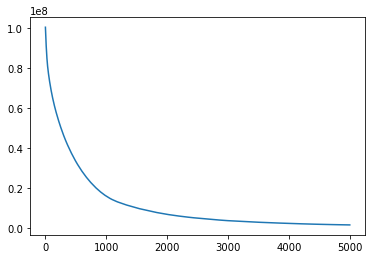

In [117]:
plt.plot(np.array(loss_trace))

0.9317388

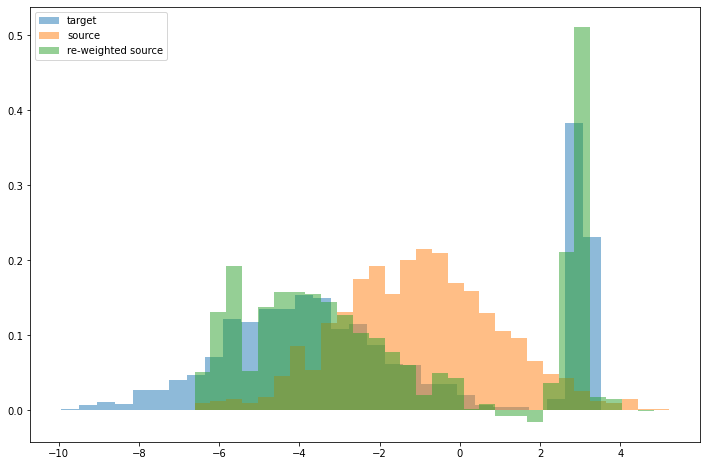

In [118]:
weights = MMDB.weights.to("cpu").detach().numpy()
viz(weights)
weights.mean()

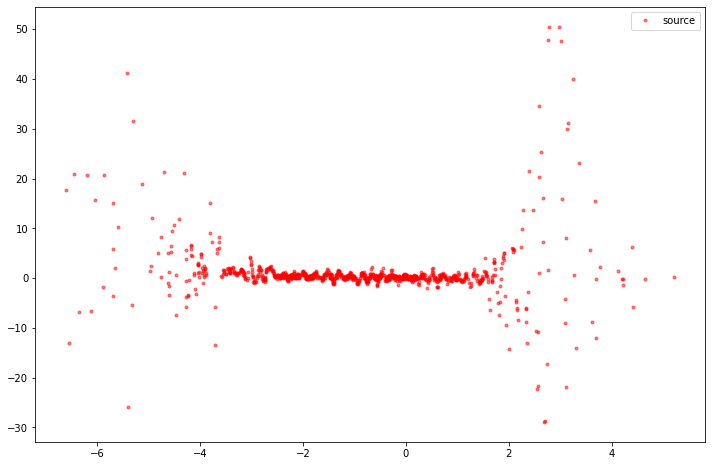

In [119]:

plt.figure(figsize = (12,8))
plt.plot(xi,weights, "r.", alpha = 0.5, label="source")
plt.legend()

In [236]:
y = MMDB.alpha
y = y.type(torch.cdouble)
#y = weights_OT.to(dev).type(torch.cdouble)
lambda_RKHS = 1e4
KXX = MMDB.KXX.type(torch.cdouble)
#important
KXX_ = torch.matmul(KXX.T,KXX)
#
#weights = torch.matmul(torch.matmul(torch.matmul(KXX,torch.linalg.inv(torch.matmul(KXX.T, KXX)+lambda_RKHS*KXX)),KXX),y)
weights = torch.matmul(torch.matmul(torch.matmul(KXX,torch.linalg.inv(torch.matmul(KXX_.T, KXX)+lambda_RKHS*KXX)),KXX_),y)

weights = torch.real(weights.to("cpu")).detach().numpy()
#weights = MMDB.alpha.to("cpu").detach().numpy()
print(np.mean(weights))


0.9624820112781567


In [242]:
#direct solves
y = torch.ones(n, dtype = torch.cdouble, device = dev)
#y = weights_OT.to(dev).type(torch.cdouble)
lambda_RKHS = 1e3
lambda_l2 = 1e-2
KXX = MMDB.KXX.type(torch.cdouble)
KXX_2 = torch.matmul(KXX.T,KXX)
KXY = MMDB.KXY.type(torch.cdouble)
alpha = torch.matmul(torch.matmul(torch.linalg.inv(torch.matmul(KXX.T, KXX)+lambda_RKHS*KXX + lambda_l2*KXX_2),KXY),y)
weights = torch.matmul(KXX,alpha)

weights = torch.real(weights.to("cpu")).detach().numpy()
#weights = MMDB.alpha.to("cpu").detach().numpy()
print(np.mean(weights))

0.8655991430058229


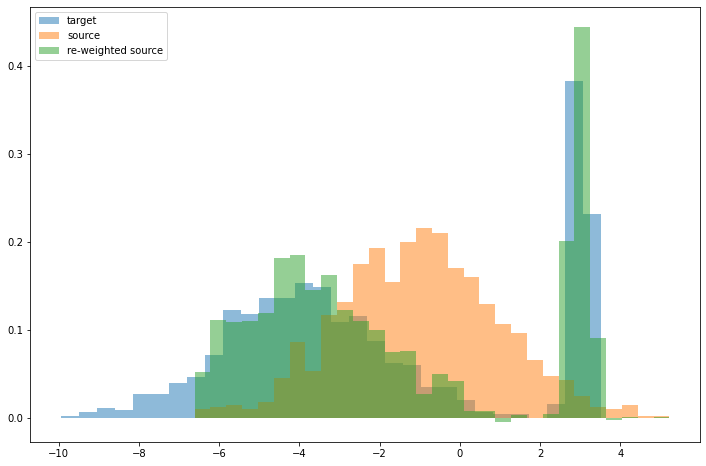

In [243]:
viz(weights)

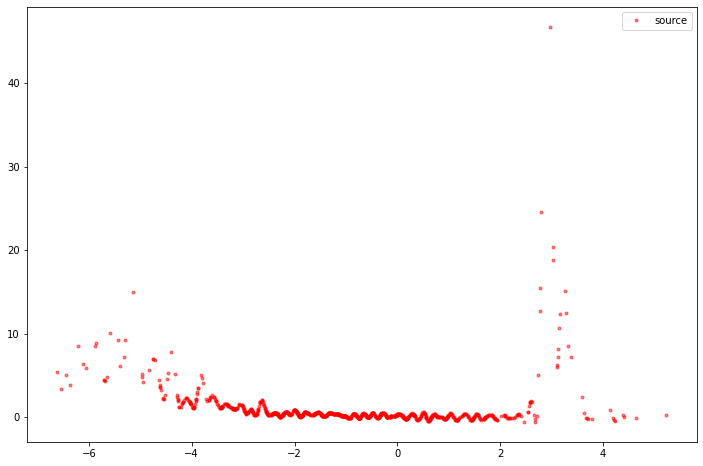

In [244]:

plt.figure(figsize = (12,8))
plt.plot(xi,weights, "r.", alpha = 0.5, label="source")
plt.legend()

C:\Users\duqim\anaconda3\lib\site-packages\numpy\lib\histograms.py:851: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
C:\Users\duqim\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\duqim\anaconda3\lib\site-packages\matplotlib\transforms.py:1966: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = float(x), float(y)


(array([  1.,   5.,  14.,  66., 236., 386., 212.,  65.,   9.,   6.]),
 array([-27.42960599+0.j, -22.40979869+0.j, -17.38999138+0.j,
        -12.37018408+0.j,  -7.35037677+0.j,  -2.33056946+0.j,
          2.68923784+0.j,   7.70904515+0.j,  12.72885245+0.j,
         17.74865976+0.j,  22.76846706+0.j]),
 <BarContainer object of 10 artists>)

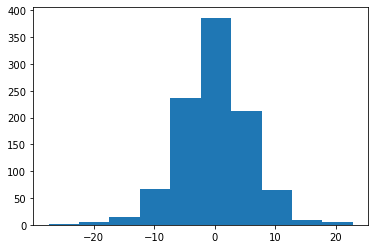

In [245]:
plt.hist(alpha.to("cpu").detach().numpy())